# Echolocation Proof of Concept: Wave Propagation Simulation

We consider the two-dimensional scalar wave equation for a field $U(x,y,t)$:

$$
\frac{\partial^2 U}{\partial t^2} = c^2 \left( \frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2} \right)
$$

where:
- $U(x,y,t)$ is the wave amplitude at spatial coordinates $(x,y)$ and time $t$,
- $c$ is the constant speed of sound in the medium.

This partial differential equation describes the propagation of acoustic waves in a homogeneous, isotropic two-dimensional space.

---

## Numerical Method

The wave equation is solved numerically using the finite difference method (FDM):

- Spatial derivatives $\frac{\partial^2}{\partial x^2}$ and $\frac{\partial^2}{\partial y^2}$ are approximated with a discrete Laplacian operator.
- Temporal derivatives $\frac{\partial^2}{\partial t^2}$ are approximated using a second-order central difference.

The resulting update rule at each grid point $(i,j)$ and timestep $t$ is:

$$
U^{t+1}_{i,j} = 2U^{t}_{i,j} - U^{t-1}_{i,j} + c^2 \Delta t^2 \nabla^2 U^{t}_{i,j}
$$

where:
- $\nabla^2$ is the discrete Laplacian of $U$,
- $\Delta t$ is the simulation timestep size.

---

## Simulation Setup

- A **chirped sonar pulse** is generated at a point source located at the center of the domain.
- **Rectangular reflective objects** are placed in the simulation field, creating echoes and scattering.
- **Hydrophones** (receivers) are positioned around the source to record the returning wave signals over time.

The simulation space is discretized into a uniform square grid (500x500), and all quantities are dimensionless.



### 1. Libraries

In [55]:
import numpy as np
from scipy.signal import chirp
from matplotlib import pyplot as plt
from scipy.signal.windows import gaussian
from numpy.random import uniform
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib.gridspec as gridspec

### 2. Class Definitions

In [56]:
class Coord2d:
    """Simple 2D coordinate class"""
    def __init__(self, x, y):
        self.x = x
        self.y = y

class SimulationDomain:
    """Defines the simulation domain in time and space"""
    def __init__(self, frames, width, height):
        self.frames = frames
        self.width = width
        self.height = height
        

class Source:
    """Defines a sonar source"""
    def __init__(self, signal, coord, spread):
        self.signal = signal        # 1D array of pulse over time
        self.coord = coord          # instance of Coord2d
        self.spread = spread        # spread radius

class Object:
    """Defines a rectangular reflective object"""
    def __init__(self, bottom_left, top_right):
        self.bottom_left = bottom_left
        self.top_right = top_right


### 3. Core Math Function


In [57]:
def laplace_op(f_xy):
    """Fast 2D Laplacian operator using array shifts"""
    left = np.roll(f_xy, -1, axis=0)
    right = np.roll(f_xy, +1, axis=0)
    up = np.roll(f_xy, -1, axis=1)
    down = np.roll(f_xy, +1, axis=1)
    return left + right + up + down - 4*f_xy


### 4. Pulse / Source / Object / Sensors Functions


In [58]:
def make_gaussian_2d(source_spread):
    """Creates a 2D Gaussian spread around the source"""
    std = source_spread /5
    gaussian_1d = gaussian(2*source_spread, std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d

def source_signal(tau):
    """Generates a chirped Gaussian pulse"""
    chirp_speed = 5
    chirp_min_freq = 0.3
    chirp_max_freq = 1
    decay_speed = 0.5
    
    chirp_sig = chirp(chirp_speed * tau, chirp_min_freq, chirp_speed * tau[-1],chirp_max_freq)
    chirplet = chirp_sig * np.exp(-(decay_speed * tau)**2)
    return chirplet

def create_source(sim, space_spread, time_spread, amp=1.0):
    """Creates a sonar source centered in the domain"""
    tau = np.linspace(-4, 4, time_spread)
    chirplet = source_signal(tau)
    signal = np.zeros(sim.frames)
    signal[0:time_spread] = chirplet * amp
    return Source(signal, Coord2d(sim.width // 2, sim.height // 2), space_spread)

def create_object(sim, width, height):
    """Creates a rectangular object in a fixed location"""
    x = sim.width // 2
    y = sim.height // 3
    return Object(Coord2d(x-width//2, y-height//2), Coord2d(x+width//2, y+height//2))

def make_sensor(dataset, sim):
    """Places hydrophones at manually defined locations"""
    sensors = [
    Coord2d(x=300, y=250),  # Mic 1 - right of center
    Coord2d(x=250, y=300),  # Mic 2 - above center
    Coord2d(x=200, y=250),  # Mic 3 - left of center
    Coord2d(x=250, y=200),  # Mic 4 - below center
    ]

    # Get signals from the dataset
    signals = []
    for mic in sensors:
        signal = dataset[:, int(mic.x), int(mic.y)]
        signals.append(signal)
    
    return sensors, signals

### 5. Contributions (sources, objects, noise)

In [59]:
def add_noise_contribution(sim, seq, noise):
    """Adds random background noise after simulation"""
    seq += uniform(-noise, noise, (sim.frames, sim.width, sim.height))

def add_source_contributions(seq, t, spread_func, source):
    """Adds source signal contribution at timestep t"""
    coord = source.coord
    r = source.spread
    seq[t, coord.x-r:coord.x+r, coord.y-r:coord.y+r] += spread_func * source.signal[t]

def add_object_contributions(seq, t, obj):
    """Applies object boundary condition at timestep t"""
    bl_x, bl_y = obj.bottom_left.x, obj.bottom_left.y
    tr_x, tr_y = obj.top_right.x, obj.top_right.y
    seq[t, bl_x:tr_x, bl_y:tr_y] = 0


### 6. WAVE SIMULATION (main loop)

In [60]:
def wave_sim(sim, source, c, obj, noise=0):
    """
    Simulates the time evolution of the sonar wave field over a 2D domain.
    Returns:
        np.ndarray: A 3D array of shape (frames, width, height) representing the wave amplitude over time.
    Method:
        - Initializes the simulation with zeros.
        - At each timestep t (starting from t=2):
            - Updates the wave field based on the discrete wave equation.
            - Injects the source signal at its location.
            - Applies object boundary conditions (e.g., blocking, reflections).
    """
    spread_func = make_gaussian_2d(source.spread)
    seq = np.zeros((sim.frames, sim.width, sim.height), dtype='float64')

    for t in range(2, sim.frames):
        seq[t] = 2*seq[t-1] - seq[t-2] + (c**2) * laplace_op(seq[t-1])  
        add_source_contributions(seq, t, spread_func, source) 
        add_object_contributions(seq, t, obj) 
    if noise > 0:
        add_noise_contribution(sim, seq, noise)
    
    return seq

### 8. Simulation Setup

In [61]:
# Define simulation domain
length = 500
sim = SimulationDomain(frames=1500, width=length, height=length)

# Create obstacle and sonar source
obj_width, obj_height = 50, 5
space_spread = 2
time_spread = sim.frames // 10
source_amp = 1.0

obj = create_object(sim, obj_width, obj_height)
source = create_source(sim, space_spread, time_spread, source_amp)
noise_amp = source_amp / 0.1


### 9. Simulation Execution

In [62]:
# Set "speed of sound" in pixels per timestep (courant number since no dimensions)
optimal_c = (length /(2 * sim.frames))
max_c = 0.4
c = min(optimal_c, max_c)

# Run simulation
dataset = wave_sim(sim, source, c, obj)

# Prepare value limits for visualization
vmin = -source_amp
vmax = source_amp

# Set up hydrophones
mics, signals = make_sensor(dataset, sim)

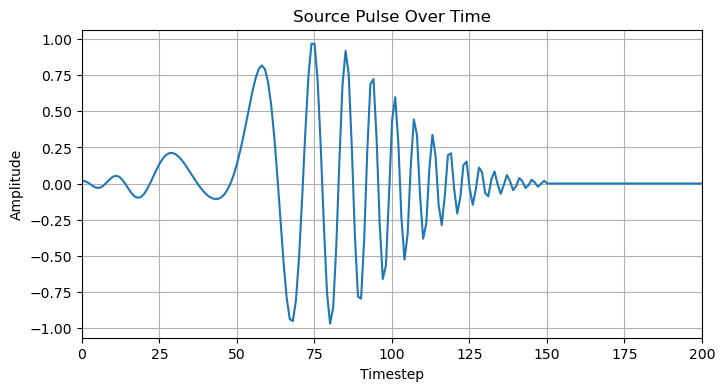

In [63]:
# Plots the shape of the injected source
t = np.linspace(0, sim.frames, sim.frames)  

# Plot the pulse
plt.figure(figsize=(8,4))
plt.plot(t, source.signal)
plt.title('Source Pulse Over Time')
plt.xlabel('Timestep')
plt.ylabel('Amplitude')
plt.xlim(0, 200)
plt.grid(True)
plt.show()


### 10. Visualization and Animation

In [64]:
# Animation settings
skip = 7
max_frames = 500
animation_fps = 15
animation_bitrate = 1500


In [ ]:
# Prepare frame data for animation
display_data = dataset[:max_frames * skip:skip]  # Downsample frames
display_frames = len(display_data)

# Mark hydrophone positions in the video data
video_data = np.copy(display_data)
for mic in mics:
    video_data[:, int(mic.x), int(mic.y)] = vmax   # Mark mic location bright

# Layout figure: 4 hydrophone signal plots (left), 1 wave animation plot (right)
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 2])

# Create hydrophone plots
signal_axes = [fig.add_subplot(gs[i, 0]) for i in range(4)]

# Create main animation plot
anim_ax = fig.add_subplot(gs[:, 1])

# Initialize plot elements
lines = [ax.plot([], [])[0] for ax in signal_axes]
anim = anim_ax.imshow(np.zeros((sim.width, sim.height)), cmap='inferno', vmin=vmin, vmax=vmax)

# Update function for each animation frame
def update(i):
    # Update wave field
    anim.set_array(video_data[i])

    # Update hydrophone signals
    t = np.arange(i * skip)  # Time axis
    for n, line in enumerate(lines):
        line.set_data(t, signals[n][:i * skip])

    return (*lines, anim)

# Style hydrophone signal plots and add titles
for idx, ax in enumerate(signal_axes, start=1):
    ax.set_facecolor("#f9f9f9")
    ax.grid(True, linestyle='--')
    ax.set_xlim(0, sim.frames)
    ax.set_ylim(-0.3, 0.3)
    ax.set_title(f"Hydrophone {idx}", fontsize=13)

# Style wave animation plot
anim_ax.set_title("Echolocation Proof of Concept: Wave Propagation Simulation", fontsize=16)
anim_ax.set_xlabel('X ')
anim_ax.set_ylabel('Y ')
anim_ax.set_xticks(np.linspace(0, sim.width, 11))
anim_ax.set_yticks(np.linspace(0, sim.height, 11))
plt.tight_layout()

# Create the animation object
ani = animation.FuncAnimation(fig, update,frames=display_frames,blit=True,interval=1000 / animation_fps,repeat=False)

# Save the animation as an mp4 video
ani.save("echolocation.mp4",dpi=80,writer=FFMpegWriter(fps=animation_fps, bitrate=animation_bitrate,codec='libx264', extra_args=["-pix_fmt", "yuv420p"]))
